github link: https://github.com/ShlomiFridman/PhoenixProject2025

In [1]:
pip install requests beautifulsoup4


In [2]:
pip install requests beautifulsoup4 nltk

In [3]:
!pip install firebase

Firebase functions

In [4]:
from firebase import firebase
FBconn = firebase.FirebaseApplication('https://lab6-b3d64-default-rtdb.europe-west1.firebasedatabase.app/',None)

get 50 pages from IBM

In [5]:
import requests
import time
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from urllib.robotparser import RobotFileParser
from nltk.stem import PorterStemmer
import re

In [14]:
# def fetch_page(url):
#     response = requests.get(url)
#     if response.status_code == 200:
#         soup = BeautifulSoup(response.text, 'html.parser')
#         return soup
#     else:
#         return None

def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index

def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index

# def search(query, index):

#    stemmer = PorterStemmer()
#    query_words = re.findall(r'\w+', query.lower())
#    print(query)
#    results = {}
#    for word in query_words:
#         word = stemmer.stem(word)
#         if word in index:
#             results[word] = index[word]
#    return results

# def search_engine(url, query):
#     soup = fetch_page(url)
#     if soup is None:
#         return None
#     index = index_words(soup)
#     index = remove_stop_words(index)
#     index = apply_stemming(index)
#     results = search(query, index)
#     return results

In [15]:
# Function to fetch and parse the robots.txt file to check permissions
def check_robot(url):
    robot_url = urljoin(url, '/robots.txt')
    rp = RobotFileParser()
    rp.set_url(robot_url)
    # Fetch and parse robots.txt file
    rp.read()
    return rp

In [16]:
# Function to fetch and parse a page
def fetch_page_crawler(url, rp):
    # Check if the URL is allowed to be crawled according to robots.txt
    if not rp.can_fetch('*', url):  # '*' means all user agents
        print(f"Blocked by robots.txt: {url}")
        return None

    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()  # Will raise an exception for 4xx or 5xx responses
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [17]:
# Function to extract internal links from a page
def extract_links(page_content, base_url):
    soup = BeautifulSoup(page_content, 'html.parser')
    links = set()

    # Find all anchor tags and extract the href attribute
    for anchor in soup.find_all('a', href=True):
        href = anchor['href']

        # Resolve relative URLs to absolute URLs
        full_url = urljoin(base_url, href)

        # Only add links that are within the same domain (ibm.com)
        if urlparse(full_url).netloc == urlparse(base_url).netloc:
            links.add(full_url)

    return links

In [25]:
# Function to crawl a website and fetch n pages
def crawl_website(base_url, max_pages):
    rp = check_robot(base_url)  # Check the robots.txt file
    crawled_urls = set()  # Set to avoid revisiting pages
    urls_to_crawl = [base_url]  # Initialize the queue with the base URL
    crawled_count = 0  # Counter for the number of crawled pages
    urls_index = {}
    ignore_urls = ["mp3", "mp4", "downloads"]

    while urls_to_crawl and crawled_count < max_pages:
        current_url = urls_to_crawl.pop(0)

        if current_url in crawled_urls:
            continue  # Skip already crawled URLs

        print(f"Crawling: {current_url}")
        page_content = fetch_page_crawler(current_url, rp)

        if page_content:
            crawled_urls.add(current_url)
            crawled_count += 1

            # Extract and queue new links to crawl
            new_links = extract_links(page_content, base_url)
            for link in new_links:
                cond = any(bad_url in link for bad_url in ignore_urls)
                if link not in crawled_urls and link not in urls_to_crawl and not cond:
                    urls_to_crawl.append(link)

            soup = BeautifulSoup(page_content, 'html.parser')
            u_index = index_words(soup)
            u_index = remove_stop_words(u_index)
            u_index = apply_stemming(u_index)
            urls_index[current_url] = u_index
            # Delay between requests to avoid overwhelming the server
            time.sleep(2)  # Sleep for 2 seconds between requests (politeness)

    print(f"\nCrawled {crawled_count} pages.")
    return crawled_urls, urls_index

In [19]:
def update_index_in_db(index_p):
  for k,v in index_p.items():
    FBconn.put("/Index/", k, v)
    print(f"update made:\n\tIndex={k}\ntValues={v}")
  print("Updated given index in DB")

the init code for the index

In [12]:
# stemmer = PorterStemmer()
# init_index = ['private', 'public', 'hybrid', 'SAAS', 'PAAS', 'IAAS', 'study', 'chatbot', 'engine', 'AI']
# stemmed_init_index = []
# for i in init_index:
#   stemmed_i = stemmer.stem(i)
#   stemmed_init_index.append([stemmed_i, {"original_index":i, "cntr":0}])
# print(f"post stemmed index: {stemmed_init_index}")
# for ind in stemmed_init_index:
#     FBconn.put("/Index/", ind[0], ind[1])
# print("Stemmed index updated in DB")

In [23]:
# Set the base URL for the IBM website or any other URL to crawl
BASE_URL = 'https://www.ibm.com/us-en'

# To limit the number of pages to crawl
MAX_PAGES = 200

urls, urls_index = crawl_website(BASE_URL, MAX_PAGES)

Crawling: https://www.ibm.com/us-en
Crawling: https://www.ibm.com/hybrid-cloud?lnk=ProdC
Crawling: https://www.ibm.com/consulting?lnk=ProdC
Crawling: https://www.ibm.com/products/watsonx-orchestrate/ai-agent-for-hr?lnk=bus
Crawling: https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus
Crawling: https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
Crawling: https://www.ibm.com/think/reports/ai-in-action?lnk=bus
Crawling: https://www.ibm.com/artificial-intelligence?lnk=ProdC
Crawling: https://www.ibm.com/granite?lnk=dev
Crawling: https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/business-trends-2025?lnk=bus
Crawling: https://www.ibm.com/watsonx/developer/?lnk=dev
Crawling: https://www.ibm.com/products/openshift
Crawling: https://www.ibm.com/consulting/aws
Crawling: https://www.ibm.com/consulting/advantage
Crawling: https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/state-of-salesforce-

get the index from DB

In [27]:
ourIndex = FBconn.get('/Index/', None)
for k,v in ourIndex.items():
  v['urls'] = []
  v["cntr"] = 0
print(ourIndex)

{'ai': {'cntr': 0, 'original_index': 'AI', 'urls': []}, 'chatbot': {'cntr': 0, 'original_index': 'chatbot', 'urls': []}, 'engin': {'cntr': 0, 'original_index': 'engine', 'urls': []}, 'hybrid': {'cntr': 0, 'original_index': 'hybrid', 'urls': []}, 'iaa': {'cntr': 0, 'original_index': 'IAAS', 'urls': []}, 'paa': {'cntr': 0, 'original_index': 'PAAS', 'urls': []}, 'privat': {'cntr': 0, 'original_index': 'private', 'urls': []}, 'public': {'cntr': 0, 'original_index': 'public', 'urls': []}, 'saa': {'cntr': 0, 'original_index': 'SAAS', 'urls': []}, 'studi': {'cntr': 0, 'original_index': 'study', 'urls': []}}


index each url

In [31]:
for u,u_vals in urls_index.items():
    print(f"Indexing url={u}")
    # soup = fetch_page(u)
    # if soup is None:
    #     continue
    # index = index_words(soup)
    # index = remove_stop_words(index)
    # index = apply_stemming(index)
    for our_ind, our_ind_vals in ourIndex.items():
      if our_ind in u_vals:
        our_ind_vals['cntr'] += u_vals[our_ind]
        our_ind_vals['urls'].append(u)

print("Finish indexing process")

Indexing url=https://www.ibm.com/us-en
Indexing url=https://www.ibm.com/hybrid-cloud?lnk=ProdC
Indexing url=https://www.ibm.com/consulting?lnk=ProdC
Indexing url=https://www.ibm.com/products/watsonx-orchestrate/ai-agent-for-hr?lnk=bus
Indexing url=https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus
Indexing url=https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
Indexing url=https://www.ibm.com/think/reports/ai-in-action?lnk=bus
Indexing url=https://www.ibm.com/artificial-intelligence?lnk=ProdC
Indexing url=https://www.ibm.com/granite?lnk=dev
Indexing url=https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/business-trends-2025?lnk=bus
Indexing url=https://www.ibm.com/watsonx/developer/?lnk=dev
Indexing url=https://www.ibm.com/products/openshift
Indexing url=https://www.ibm.com/consulting/aws
Indexing url=https://www.ibm.com/consulting/advantage
Indexing url=https://www.ibm.com/thought-leadership/institute-bus

display results, and save them in DB

In [32]:
for ind,vals in ourIndex.items():
  urls_str = '\n\t\t'.join(vals['urls'])
  print(f"Index: '{ind}'\n\tTotal Count: {vals['cntr']}\n\tUrls: {urls_str}")

Index: 'ai'
	Total Count: 5320
	Urls: https://www.ibm.com/us-en
		https://www.ibm.com/hybrid-cloud?lnk=ProdC
		https://www.ibm.com/consulting?lnk=ProdC
		https://www.ibm.com/products/watsonx-orchestrate/ai-agent-for-hr?lnk=bus
		https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus
		https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
		https://www.ibm.com/think/reports/ai-in-action?lnk=bus
		https://www.ibm.com/artificial-intelligence?lnk=ProdC
		https://www.ibm.com/granite?lnk=dev
		https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/business-trends-2025?lnk=bus
		https://www.ibm.com/watsonx/developer/?lnk=dev
		https://www.ibm.com/products/openshift
		https://www.ibm.com/consulting/aws
		https://www.ibm.com/consulting/advantage
		https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/state-of-salesforce-2024
		https://www.ibm.com/account/reg/signup?formid=urx-52503
		https://www.ibm.com

chart for the counter of each index

<ipython-input-33-903c40db70f6>:16: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(x="Index", y="Appearances",


<Figure size 640x480 with 0 Axes>

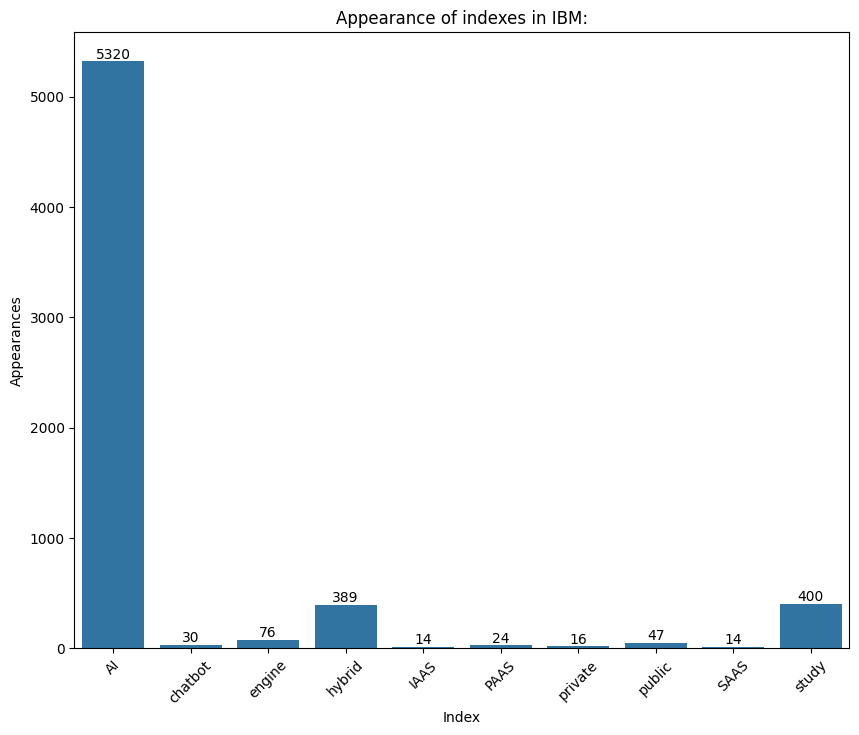

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ind_names = [ind["original_index"] for ind in ourIndex.values()]
ind_cntrs = [ind["cntr"] for ind in ourIndex.values()]
ind_data = pd.DataFrame({
    "Index":ind_names,
    "Appearances":ind_cntrs
})

plt.clf()  # Clear the current figure
plt.figure(figsize=(10, 8))  # Increased figure size to accommodate labels
plt.title("Appearance of indexes in IBM:")

ax = sns.barplot(x="Index", y="Appearances",
                 errwidth=0, data=ind_data)
for i in ax.containers:
  ax.bar_label(i,)
plt.xticks(rotation=45)
plt.show()  # Add this to display the plot
plt.close()  # Close the figure to free memory

In [34]:
update_index_in_db(ourIndex)

update made:
	Index=ai
tValues={'cntr': 5320, 'original_index': 'AI', 'urls': ['https://www.ibm.com/us-en', 'https://www.ibm.com/hybrid-cloud?lnk=ProdC', 'https://www.ibm.com/consulting?lnk=ProdC', 'https://www.ibm.com/products/watsonx-orchestrate/ai-agent-for-hr?lnk=bus', 'https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus', 'https://www.ibm.com/products/watsonx-code-assistant?lnk=dev', 'https://www.ibm.com/think/reports/ai-in-action?lnk=bus', 'https://www.ibm.com/artificial-intelligence?lnk=ProdC', 'https://www.ibm.com/granite?lnk=dev', 'https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/business-trends-2025?lnk=bus', 'https://www.ibm.com/watsonx/developer/?lnk=dev', 'https://www.ibm.com/products/openshift', 'https://www.ibm.com/consulting/aws', 'https://www.ibm.com/consulting/advantage', 'https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/state-of-salesforce-2024', 'https://www.ibm.com/